In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0.zip to GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0.zip
User uploaded file "GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0.zip" with length 141862277 bytes


In [21]:
!unzip GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0.zip

Archive:  GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0.zip
   creating: GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0/
  inflating: GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0/exp_config.txt  
   creating: __MACOSX/GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0/
  inflating: __MACOSX/GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0/._exp_config.txt  
  inflating: GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_le

In [0]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt


def clones(module, N):
  "A helper function for producing N identical layers (each with their own parameters)."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# NOTE ==============================================
#
# Fill in code for every method which has a TODO
#
# Your implementation should use the contract (inputs
# and outputs) given for each model, because that is
# what the main script expects. If you modify the contract,
# you must justify that choice, note it in your report, and notify the TAs
# so that we run the correct code.
#
# You may modify the internals of the RNN and GRU classes
# as much as you like, except you must keep the methods
# in each (init_weights_uniform, init_hidden, and forward)
# Using nn.Module and "forward" tells torch which
# parameters are involved in the forward pass, so that it
# can correctly (automatically) set up the backward pass.
#
# You should not modify the interals of the Transformer
# except where indicated to implement the multi-head
# attention.


class GRU_cell(nn.Module): # Implement a stacked GRU RNN
  """
  Follow the same instructions as for RNN (above), but use the equations for
  GRU, not Vanilla RNN.
  """
  def __init__(self, emb_size, hidden_size):
    super(GRU_cell, self).__init__()
    self.emb_size = emb_size
    self.hidden_size = hidden_size

    self.W_x = nn.Parameter(torch.Tensor(emb_size,3*hidden_size))
    self.U_h = nn.Parameter(torch.Tensor(hidden_size,2*hidden_size))
    self.U_h_tilde = nn.Parameter(torch.Tensor(hidden_size,hidden_size))
    self.bias_rzh = nn.Parameter(torch.Tensor(3*hidden_size))

    self.init_weights_uniform()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

  def init_weights_uniform(self):
    # Initialize all other (i.e. recurrent and linear) weights AND biases uniformly
    # in the range [-k, k] where k is the square root of 1/hidden_size
    k = math.sqrt(1.0/self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-k, k)

    torch.nn.init.zeros_(self.bias_rzh)

  def forward(self, inputs, hidden):
    """
    Arguments:
        - inputs: A mini-batch of input sequences, composed of integers that
                    represent the index of the current token(s) in the vocabulary.
                        shape: (batch_size, embedding)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (batch_size, hidden_size)
    """
    batch_size = hidden.size(0)

    bias_rzh_batch = self.bias_rzh.unsqueeze(0).expand(batch_size, self.bias_rzh.size(0))
    W_x = torch.addmm(bias_rzh_batch,inputs,self.W_x)
    U_h_prev = torch.mm(hidden,self.U_h)
    W_rx, W_zx, W_hx = torch.split(W_x,self.hidden_size, dim=1)
    U_rh, U_zh = torch.split(U_h_prev,self.hidden_size, dim=1)

    r = self.sigmoid(W_rx + U_rh)
    z = self.sigmoid(W_zx + U_zh)
    h_tilde = self.tanh(W_hx + torch.mm(r * hidden,self.U_h_tilde))
    h = ((1-z) * hidden) + (z * h_tilde)

    return h

# Problem 2
class GRU(nn.Module): # Implement a stacked GRU RNN
  """
  Follow the same instructions as for RNN (above), but use the equations for
  GRU, not Vanilla RNN.
  """
  def __init__(self, emb_size, hidden_size, seq_len, batch_size, vocab_size, num_layers, dp_keep_prob):
    """
    emb_size:     The number of units in the input embeddings
    hidden_size:  The number of hidden units per layer
    seq_len:      The length of the input sequences
    vocab_size:   The number of tokens in the vocabulary (10,000 for Penn TreeBank)
    num_layers:   The depth of the stack (i.e. the number of hidden layers at
                  each time-step)
    dp_keep_prob: The probability of *not* dropping out units in the
                  non-recurrent connections.
                  Do not apply dropout on recurrent connections.
    """
    super(GRU, self).__init__()
    self.emb_size = emb_size
    self.hidden_size = hidden_size
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.num_layers = num_layers

    # Keep hidden layers result when we want to compute the avg gradients
    self.hiddens = []

    self.embedding = nn.Embedding(vocab_size, emb_size)
    self.decode = nn.Linear(hidden_size, vocab_size)

    self.dropout = nn.Dropout(1 - dp_keep_prob)
    self.softmax = nn.Softmax(dim=2)
    self.gen_softmax = nn.Softmax(dim=1)

    # Weight initialization (Embedding has no bias)
    self.init_weights_uniform(self.embedding, init_bias=False)
    self.init_weights_uniform(self.decode, init_bias=True)

    self.GRU_cells = nn.ModuleList([GRU_cell(emb_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

    # Initialization of the parameters of the recurrent and fc layers.
    # Your implementation should support any number of stacked hidden layers
    # (specified by num_layers), use an input embedding layer, and include fully
    # connected layers with dropout after each recurrent layer.
    # Note: you may use pytorch's nn.Linear, nn.Dropout, and nn.Embedding
    # modules, but not recurrent modules.
    #
    # To create a variable number of parameter tensors and/or nn.Modules
    # (for the stacked hidden layer), you may need to use nn.ModuleList or the
    # provided clones function (as opposed to a regular python list), in order
    # for Pytorch to recognize these parameters as belonging to this nn.Module
    # and compute their gradients automatically. You're not obligated to use the
    # provided clones function.

  def init_weights_uniform(self, layer, init_bias=False):
    """
    # Initialize the embedding and output weights uniformly in the range [-0.1, 0.1]
    # and output biases to 0 (in place). The embeddings should not use a bias vector.
    """
    torch.nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
    if init_bias:
        torch.nn.init.constant_(layer.bias, 0)

  def init_hidden(self):
    # initialize the hidden states to zero
    """
    This is used for the first mini-batch in an epoch, only.
    """
    return torch.zeros(self.num_layers, self.batch_size, self.hidden_size)

  def forward(self, inputs, hidden, keep_hiddens=False):
    # Compute the forward pass, using a nested python for loops.
    # The outer for loop should iterate over timesteps, and the
    # inner for loop should iterate over hidden layers of the stack.
    #
    # Within these for loops, use the parameter tensors and/or nn.modules you
    # created in __init__ to compute the recurrent updates according to the
    # equations provided in the .tex of the assignment.
    #
    # Note that those equations are for a single hidden-layer RNN, not a stacked
    # RNN. For a stacked RNN, the hidden states of the l-th layer are used as
    # inputs to to the {l+1}-st layer (taking the place of the input sequence).

    """
    Arguments:
        - inputs: A mini-batch of input sequences, composed of integers that
                    represent the index of the current token(s) in the vocabulary.
                        shape: (seq_len, batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)
    Returns:
        - Logits for the softmax over output tokens at every time-step.
              **Do NOT apply softmax to the outputs!**
              Pytorch's CrossEntropyLoss function (applied in ptb-lm.py) does
              this computation implicitly.
                    shape: (seq_len, batch_size, vocab_size)
        - The final hidden states for every layer of the stacked RNN.
              These will be used as the initial hidden states for all the
              mini-batches in an epoch, except for the first, where the return
              value of self.init_hidden will be used.
              See the repackage_hiddens function in ptb-lm.py for more details,
              if you are curious.
                    shape: (num_layers, batch_size, hidden_size)
    """
    self.hiddens = []
    h_previous_ts = hidden
    logits = []
    embeddings = self.embedding(inputs)
    for t in range(self.seq_len):
      h_next_ts = []
      input = self.dropout(embeddings[t])
      for h_index in range(self.num_layers):
        # Recurrent GRU cell
        h_recurrent = self.GRU_cells[h_index].forward(input, h_previous_ts[h_index])
        if keep_hiddens:
            self.hiddens.append(h_recurrent)
        # Fully connected layer with dropout
        h_previous_layer = self.dropout(h_recurrent)
        input = h_previous_layer # used vertically up the layers
        # Keep the ref for next ts
        h_next_ts.append(h_recurrent) # used horizontally across timesteps
      h_previous_ts = torch.stack(h_next_ts)
      logits.append(self.decode(h_previous_layer))
    return torch.stack(logits), h_next_ts

  def generate(self, input, hidden, generated_seq_len, device):  # generate next word using the GRU
    # Compute the forward pass, as in the self.forward method (above).
    # You'll probably want to copy substantial portions of that code here.
    #
    # We "seed" the generation by providing the first inputs.
    # Subsequent inputs are generated by sampling from the output distribution,
    # as described in the tex (Problem 5.3)
    # Unlike for self.forward, you WILL need to apply the softmax activation
    # function here in order to compute the parameters of the categorical
    # distributions to be sampled from at each time-step.

    """
    Arguments:
        - input: A mini-batch of input tokens (NOT sequences!)
                        shape: (batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)
        - generated_seq_len: The length of the sequence to generate.
                       Note that this can be different than the length used
                       for training (self.seq_len)
    Returns:
        - Sampled sequences of tokens
                    shape: (generated_seq_len, batch_size)
    """
    self.eval()
    input = input[0]
    samples = []
    h_previous_ts = hidden
    new_input = input

    for t in range(generated_seq_len):
      h_next_ts = []
      new_input = new_input.to(device)
      embedding = self.embedding(new_input)
      input = embedding
      for h_index in range(self.num_layers):
        # Recurrent GRU cell
        h_recurrent = self.GRU_cells[h_index].forward(input, h_previous_ts[h_index])
        # Fully connected layer with dropout
        h_previous_layer = self.dropout(h_recurrent)
        input = h_previous_layer  # used vertically up the layers
        # Keep the ref for next ts
        h_next_ts.append(h_recurrent)  # used horizontally across timesteps

      h_previous_ts = torch.stack(h_next_ts)

      sample = h_previous_layer
      sample = self.gen_softmax(self.decode(sample))
      sample_index = int(np.argmax(sample.cpu().detach().numpy()))
      samples.append(sample_index)
      new_input[0] = sample_index

    return samples

In [0]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt


# NOTE ==============================================
#
# Your implementation should use the contract (inputs
# and outputs) given for each model, because that is
# what the main script expects. If you modify the contract,
# you must justify that choice, note it in your report, and notify the TAs
# so that we run the correct code.
#
# You may modify the internals of the RNN and GRU classes
# as much as you like, except you must keep the methods
# in each (init_weights_uniform, init_hidden, and forward)
# Using nn.Module and "forward" tells torch which
# parameters are involved in the forward pass, so that it
# can correctly (automatically) set up the backward pass.
#
# You should not modify the interals of the Transformer
# except where indicated to implement the multi-head
# attention.


def clones(module, N):
    "A helper function for producing N identical layers (each with their own parameters)."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Problem 1
class RNN(nn.Module): # Implement a stacked vanilla RNN with Tanh nonlinearities.
  def __init__(self, emb_size, hidden_size, seq_len, batch_size, vocab_size, num_layers=2, dp_keep_prob=0.5):

    """
    emb_size:     The numvwe of units in the input embeddings
    hidden_size:  The number of hidden units per layer
    seq_len:      The length of the input sequences
    vocab_size:   The number of tokens in the vocabulary (10,000 for Penn TreeBank)
    num_layers:   The depth of the stack (i.e. the number of hidden layers at
                  each time-step)
    dp_keep_prob: The probability of *not* dropping out units in the
                  non-recurrent connections.
                  Do not apply dropout on recurrent connections.
    """
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.vocab_size = vocab_size

    # To compute the average gradient
    self.hiddens = []

    # Embedding encoder
    self.embedding = nn.Embedding(vocab_size, emb_size)

    # N stacked recurrent layers (first layer has different input size)
    linear_W0 = nn.Linear(emb_size, hidden_size)
    self.init_weights_uniform_0(nn.Linear(hidden_size, hidden_size))
    linear_W = [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)]
    for layer in linear_W:
        self.init_weights_uniform_0(layer)
    self.linear_W = nn.ModuleList([linear_W0] + linear_W)
    linear_U = nn.Linear(hidden_size, hidden_size)
    self.init_weights_uniform_0(linear_U)
    self.linear_U = clones(linear_U, num_layers)

    # Embedding decoder
    self.decode = nn.Linear(hidden_size, vocab_size)

    self.dropout = nn.Dropout(1 - dp_keep_prob)
    self.activation = nn.Tanh()
    self.softmax = nn.Softmax(dim=2)

    # Weight initialization (Embedding has no bias)
    self.init_weights_uniform(self.embedding, init_bias=False)
    self.init_weights_uniform(self.decode, init_bias=True)

  def init_weights_uniform(self, layer, init_bias=False):
    """
    Initialize all the weights uniformly in the range [-0.1, 0.1]
    and all the biases to 0 (in place)
    """
    torch.nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
    if init_bias:
        torch.nn.init.constant_(layer.bias, 0)

  def init_weights_uniform_0(self, layer, init_bias=True):
    # Initialize all other (i.e. recurrent and linear) weights AND biases uniformly
    # in the range [-k, k] where k is the square root of 1/hidden_size
    k = math.sqrt(1.0/self.hidden_size)
    torch.nn.init.uniform_(layer.weight, a=-k, b=k)
    if init_bias:
        torch.nn.init.constant_(layer.bias, 0)


  def init_hidden(self):
    """
    This is used for the first mini-batch in an epoch, only.
    """
    return torch.zeros(self.num_layers, self.batch_size, self.hidden_size)

  def forward(self, inputs, hidden, keep_hiddens=False):
    """
    Arguments:
        - inputs: A mini-batch of input sequences, composed of integers that
                    represent the index of the current token(s) in the vocabulary.
                        shape: (seq_len, batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)
    Returns:
        - Logits for the softmax over output tokens at every time-step.
              **Do NOT apply softmax to the outputs!**
              Pytorch's CrossEntropyLoss function (applied in ptb-lm.py) does
              this computation implicitly.
                    shape: (seq_len, batch_size, vocab_size)
        - The final hidden states for every layer of the stacked RNN.
              These will be used as the initial hidden states for all the
              mini-batches in an epoch, except for the first, where the return
              value of self.init_hidden will be used.
              See the repackage_hiddens function in ptb-lm.py for more details,
              if you are curious.
                    shape: (num_layers, batch_size, hidden_size)
    """
    if keep_hiddens:
        self.hiddens = []
    h_previous_ts = hidden
    seq_logits = []
    emb = self.embedding(inputs)
    for i in range(self.seq_len):
        logits, h_previous_ts = self._forward_single_token_embedding(emb[i], h_previous_ts, keep_hiddens)
        seq_logits.append(logits)
    return torch.stack(seq_logits), h_previous_ts

  def _forward_single_token_embedding(self, embedding, h_previous_ts, keep_hiddens=False):
    """
    Forward pass for a single token embedding given the
    hidden state at the previous time step
    """
    h_next_ts = []
    h_previous_layer = self.dropout(embedding)
    for l in range(self.num_layers):
        # Recurrent layer
        a_W = self.linear_W[l](h_previous_layer)
        a_U = self.linear_U[l](h_previous_ts[l])
        h_recurrent = self.activation(a_U + a_W)
        if keep_hiddens:
            self.hiddens.append(h_recurrent)
        # Fully connected layer
        h_previous_layer = self.dropout(h_recurrent)
        # Keep the ref for next ts
        h_next_ts.append(h_recurrent)
    h_previous_ts = torch.stack(h_next_ts)
    logits = self.decode(h_previous_layer)
    return logits, h_previous_ts

  def generate(self, input, hidden, generated_seq_len, device):
    """
    Arguments:
        - input: A mini-batch of input tokens (NOT sequences!)
                        shape: (batch_size)
        - hidden: The initial hidden states for every layer of the stacked RNN.
                        shape: (num_layers, batch_size, hidden_size)
        - generated_seq_len: The length of the sequence to generate.
                       Note that this can be different than the length used
                       for training (self.seq_len)
    Returns:
        - Sampled sequences of tokens
                    shape: (generated_seq_len, batch_size)
    """
    # Model in eval mode
    self.eval()

    samples = []
    h_previous_ts = hidden
    new_input = input
    for i in range(generated_seq_len):
        new_input = new_input.to(device)
        emb = self.embedding(new_input)
        logits, h_previous_ts = self._forward_single_token_embedding(emb, h_previous_ts)
        sample = self.softmax(logits)
        sample_index = int(np.argmax(sample.cpu().detach().numpy()))
        samples.append(sample_index)
        new_input[0, 0] = sample_index
    return samples

In [23]:
#!/bin/python
# coding: utf-8

import collections
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#from GRU_RNN import GRU
#from simple_RNN import RNN


# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print("WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage")
    device = torch.device("cpu")


###############################################################################
#
# DATA LOADING & PROCESSING
#
###############################################################################

# HELPER FUNCTIONS
def _read_words(filename):
    with open(filename, "r") as f:
      return f.read().replace("\n", "<eos>").split()

def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict((v, k) for k, v in word_to_id.items())

    return word_to_id, id_to_word

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]

# Processes the raw data from text files
def ptb_raw_data(data_path=None, prefix="ptb"):
    train_path = os.path.join(data_path, prefix + ".train.txt")
    valid_path = os.path.join(data_path, prefix + ".valid.txt")
    test_path = os.path.join(data_path, prefix + ".test.txt")

    word_to_id, id_2_word = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)
    return train_data, valid_data, test_data, word_to_id, id_2_word

# Yields minibatches of data
def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)


class Batch:
    "Data processing for the transformer. This class adds a mask to the data."
    def __init__(self, x, pad=-1):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."

        def subsequent_mask(size):
            """ helper function for creating the masks. """
            attn_shape = (1, size, size)
            subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
            return torch.from_numpy(subsequent_mask) == 0

        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(
            subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask


# LOAD DATA
print('Loading data from '+ 'data')
raw_data = ptb_raw_data(data_path='data')
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('  vocabulary size: {}'.format(vocab_size))


###############################################################################
#
# MODEL SETUP
#
###############################################################################


###############################################################################
#
# DEFINE COMPUTATIONS FOR PROCESSING ONE EPOCH
#
###############################################################################

def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.
    This prevents Pytorch from trying to backpropagate into previous input
    sequences when we use the final hidden states from one mini-batch as the
    initial hidden states for the next mini-batch.
    Using the final hidden states in this way makes sense when the elements of
    the mini-batches are actually successive subsequences in a set of longer sequences.
    This is the case with the way we've processed the Penn Treebank dataset.
    """
    if isinstance(h, Variable):
        return h.detach_()
    else:
        return tuple(repackage_hidden(v) for v in h)


def compute_average_grad(model, data, model_name):
    model.eval()

    if model_name != 'TRANSFORMER':
        hidden = model.init_hidden()
        hidden = hidden.to(device)

    for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.seq_len)):
        # Prepare data
        inputs = torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous().to(device)
        model.zero_grad()
        hidden = repackage_hidden(hidden)
        # Forward pass
        outputs, hidden = model(inputs, hidden, keep_hiddens=True)
        targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)
        # Resize
        tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))
        out = outputs.contiguous().view(-1, model.vocab_size)
        # Compute the loss
        loss = loss_fn(out, tt)
        # Get the euclidian norm of the gradients with respect to each hidden layer
        grads = [float(torch.autograd.grad(loss, hidden, retain_graph=True)[0].norm(2).cpu().numpy()) for hidden in model.hiddens]
        # Return the result for the first and second hidden layer separately
        
        return grads[0::2], grads[1::2]


###############################################################################
#
# RUN MAIN LOOP (TRAIN AND VAL)
#
###############################################################################

print("\n########## Running Main Loop ##########################")


# MAIN LOOP

RNN_PATH = 'RNN_ADAM_model=RNN_optimizer=ADAM_initial_lr=0.0001_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.6_save_best_0'
GRU_PATH = 'GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0'

EMB_SIZE_RNN = 200
HIDDEN_SIZE_RNN = 1500
SEQ_LEN_RNN = 35
BATCH_SIZE_RNN = 20
VOCAB_SIZE_RNN = 10000
NUM_LAYERS_RNN = 2
DP_KEEP_PROB_RNN = 0.6

EMB_SIZE_GRU = 200
HIDDEN_SIZE_GRU = 1500
SEQ_LEN_GRU = 35
BATCH_SIZE_GRU = 20
VOCAB_SIZE_GRU = 10000
NUM_LAYERS_GRU = 2
DP_KEEP_PROB_GRU = 0.35

# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

word_to_id, id_2_word = _build_vocab(os.path.join('data', 'ptb' + ".train.txt"))

# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()



model_classes = [RNN, GRU]
for model_class in model_classes:
    if model_class == RNN:
        MODEL_PATH = RNN_PATH
        model = model_class(emb_size=EMB_SIZE_RNN,
                    hidden_size=HIDDEN_SIZE_RNN,
                    seq_len=SEQ_LEN_RNN,
                    batch_size=BATCH_SIZE_RNN,
                    vocab_size=VOCAB_SIZE_RNN,
                    num_layers=NUM_LAYERS_RNN,
                    dp_keep_prob=DP_KEEP_PROB_RNN)
        model_name = 'RNN'

    if model_class == GRU:
        MODEL_PATH = GRU_PATH
        model = model_class(emb_size=EMB_SIZE_GRU,
                    hidden_size=HIDDEN_SIZE_GRU,
                    seq_len=SEQ_LEN_GRU,
                    batch_size=BATCH_SIZE_GRU,
                    vocab_size=VOCAB_SIZE_GRU,
                    num_layers=NUM_LAYERS_GRU,
                    dp_keep_prob=DP_KEEP_PROB_GRU)
        model_name = 'GRU'

    load_path = os.path.join(MODEL_PATH, 'best_params.pt')
    model.load_state_dict(torch.load(load_path))

    model = model.to(device)
    first_layer_grads, second_layer_grads = compute_average_grad(model, train_data, model_name)

    print(model_name)
    print('First layer: {}'.format(first_layer_grads))
    print('Second layer: {}'.format(second_layer_grads))
    if model_name == 'RNN':
        RNN_first_layer_grad = first_layer_grads
        RNN_second_layer_grad = second_layer_grads
    if model_name == 'GRU':
        GRU_first_layer_grad = first_layer_grads
        GRU_second_layer_grad = second_layer_grads
        

# plt.plot(loss_array, '-o', label=model_name)

# plt.title("Norm of Gradients Vs. Timesteps")
# plt.ylabel("Norm of Gradients")
# plt.xlabel("Timestep")
# plt.legend()
# plt.savefig("Q5.2_PLOT.jpg")

Using the GPU
Loading data from data
  vocabulary size: 10000

########## Running Main Loop ##########################
Using the GPU
RNN
First layer: [0.03999697417020798, 0.039250969886779785, 0.0377032607793808, 0.03668290004134178, 0.03544052317738533, 0.03535144403576851, 0.0340891033411026, 0.033654630184173584, 0.03432830423116684, 0.03415659815073013, 0.034264806658029556, 0.034579094499349594, 0.03409448638558388, 0.03160100430250168, 0.031142782419919968, 0.030931876972317696, 0.031229566782712936, 0.03189348056912422, 0.03214060515165329, 0.03141254186630249, 0.03156454488635063, 0.03164895996451378, 0.03168894350528717, 0.030662769451737404, 0.0304762851446867, 0.029834257438778877, 0.029254434630274773, 0.029751453548669815, 0.03095933049917221, 0.030185464769601822, 0.028158720582723618, 0.027110319584608078, 0.024655411019921303, 0.020492292940616608, 0.015138499438762665]
Second layer: [0.018962986767292023, 0.01905764825642109, 0.018883123993873596, 0.01870482787489891,

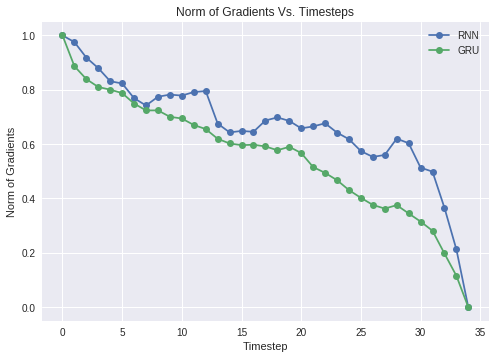

In [27]:
RNN_norm = []
GRU_norm = []

for i in range(35):
    rnn_norm = np.linalg.norm([RNN_first_layer_grad[i], RNN_second_layer_grad[i]])
    RNN_norm.append(rnn_norm)
    gru_norm = np.linalg.norm([GRU_first_layer_grad[i], GRU_second_layer_grad[i]])
    GRU_norm.append(gru_norm)

RNN_norm = np.array(RNN_norm)
GRU_norm = np.array(GRU_norm)
rnn_norm_rescale = (RNN_norm - np.min(RNN_norm))/np.ptp(RNN_norm)
gru_norm_rescale = (GRU_norm - np.min(GRU_norm))/np.ptp(GRU_norm)

plt.plot(rnn_norm_rescale, '-o', label='RNN')
plt.plot(gru_norm_rescale, '-o', label='GRU')

plt.title("Norm of Gradients Vs. Timesteps")
plt.ylabel("Norm of Gradients")
plt.xlabel("Timestep")
plt.legend()
plt.show()